In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image, SVG, display  
import pydotplus
import os
from ipywidgets import interactive
from graphviz import Source
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


import warnings
warnings.filterwarnings("ignore")

In [2]:
bigrams = pd.read_csv("bigram_count.csv")
df = bigrams[pd.notnull(bigrams["score_0"])]
bigs = df.columns[1:201]

In [3]:
b2 = bigrams.copy()
b2r = b2[b2["party"]=="R"]
b2d = b2[b2["party"]=="D"]
for i, b in enumerate(bigs):
    b2r[b] = np.where(b2r[b] >= 1, 1, 0)
    b2d[b] = np.where(b2d[b] >= 1, 1, 0)
    if i % 20 == 0:
        print(i)

0
20
40
60
80
100
120
140
160
180


In [4]:
b2ds = b2d[bigs].sum()
b2rs = b2r[bigs].sum()

In [5]:
# Approach 1: Score by total frequency
reps = []
dems = []

rt = []
dt = []
rscores = []
for b in bigs:
    rtotal = df[df["party"]=="R"][b].sum()
    dtotal = df[df["party"]=="D"][b].sum()
    total = rtotal + dtotal
    rscore = rtotal / total
    if (rscore >= 0.60):
        reps.append(b)
    elif (rscore <= 0.40):
        dems.append(b)
    rt.append(rtotal)
    dt.append(dtotal)
    rscores.append(rscore)

In [6]:
# Approach 2: Score by Indicator (% of Repubs who have said bigram)
reps2 = []
dems2 = []

rt2 = []
dt2 = []
rscores2 = []
for b in bigs:
    rtotal = b2rs[b]
    dtotal = b2ds[b]
    total = rtotal + dtotal
    rscore = rtotal / total
    if (rscore >= 0.60):
        reps2.append(b)
    elif (rscore <= 0.40):
        dems2.append(b)
    rt2.append(rtotal)
    dt2.append(dtotal)
    rscores2.append(rscore)

In [7]:
bigsdf2 = pd.DataFrame({"bigram": bigs, "rtotal": rt2, "dtotal": dt2, "rscore": rscores, "rscore2": rscores2, "diff": abs(np.array(rscores) - np.array(rscores2))})
bigsdf2["r_lean"] = np.where((bigsdf2["rscore2"] >= 0.60) & (bigsdf2["rscore"] < 0.75), 1, 0)
bigsdf2["r_solid"] = np.where(bigsdf2["rscore2"] >= 0.75, 1, 0)
bigsdf2["d_lean"] = np.where((bigsdf2["rscore2"] <= 0.40) & (bigsdf2["rscore"] > 0.25), 1, 0)
bigsdf2["d_solid"] = np.where(bigsdf2["rscore2"] <= 0.25, 1, 0)
bigsdf2.head()

,bigram,rtotal,dtotal,rscore,rscore2,diff,r_lean,r_solid,d_lean,d_solid
0,"(000,jobs)",117,20,0.911765,0.854015,0.057750,0,1,0,0
1,"(100,days)",45,115,0.258462,0.281250,0.022788,0,0,1,0
2,"(116th,congress)",85,100,0.464407,0.459459,0.004947,0,0,0,0
3,"(2019,congressional)",48,53,0.512048,0.475248,0.036801,0,0,0,0
4,"(21st,century)",47,64,0.410714,0.423423,0.012709,0,0,0,0


In [8]:
r_lean = df[bigsdf2[bigsdf2["r_lean"] == 1]["bigram"].values].sum(1)
r_solid = df[bigsdf2[bigsdf2["r_solid"] == 1]["bigram"].values].sum(1)
d_lean = df[bigsdf2[bigsdf2["d_lean"] == 1]["bigram"].values].sum(1)
d_solid = df[bigsdf2[bigsdf2["d_solid"] == 1]["bigram"].values].sum(1)
total = r_lean + r_solid + d_lean + d_solid

df_leans2 = pd.DataFrame({
    "custom_id": df["custom_id"], "name": df["name"], "is_rep": np.where(df["party"] == "R", 1, 0), "position": df["position"], 
    "r_lean": r_lean, "r_solid": r_solid, "rt": r_lean + r_solid, 
    "d_lean": d_lean, "d_solid": d_solid, "dt": d_lean + d_solid,
    "total": total, "score": df["score_0"]
})
print(df_leans2.shape)
print("\t\t\t Bigram Frequencies (Categorized)")
df_leans2.head()


(527, 12)
			 Bigram Frequencies (Categorized)


,custom_id,name,is_rep,position,r_lean,r_solid,rt,d_lean,d_solid,dt,total,score
0,263,Abby Finkenauer,0,H,0,0,0,12,15,27,27,0.000000
1,516,Abigail Spanberger,0,H,1,0,1,25,11,36,37,0.000000
2,242,Adam Kinzinger,1,H,5,13,18,10,1,11,29,0.934426
3,142,Adam Schiff,0,H,0,0,0,54,38,92,92,0.178862
4,528,Adam Smith,0,H,2,0,2,29,49,78,80,0.111111


In [9]:
def scale(x, min_num, max_num, scale_min=0, scale_max=1):
    return (x - min_num) * (scale_max - scale_min) / (max_num - min_num) + scale_min
# (X_test["pred_score"] - min(X_test["pred_score"])) * (1 - 0) / (max(X_test["pred_score"]) - min(X_test["pred_score"])) + 0


In [10]:
# Final Logistic Regression Model (Predict Party)

X_train, X_test, y_train, y_test = train_test_split(df_leans2, df_leans2["is_rep"], test_size=0.25)
X_train["dli"] = 1 / X_train["d_lean"]
cols = ["rt", "dt"]


predict_party_model = LogisticRegression()
predict_party_model.fit(X_train[cols], y_train)
print(predict_party_model.score(X_train[cols], y_train))

X_train["pred_rep"] = predict_party_model.predict(X_train[cols])
X_test["pred_rep"] = predict_party_model.predict(X_test[cols])
print(sum(X_test["is_rep"] == X_test["pred_rep"]) / len(X_test["pred_rep"]))
# X_test.head()

# Final Linear Regression Model (Predict Trump Score)
cols = ["r_lean", "r_solid", "d_lean", "d_solid", "pred_rep"]
predict_ts_model = LinearRegression()

predict_ts_model.fit(X_train[cols], y_train)

print(predict_ts_model.score(X_train[cols], (y_train)))


X_test["pred_score"] = predict_ts_model.predict(X_test[cols])
X_test["pred_score"] = scale(X_test["pred_score"], min(X_test["pred_score"]), max(X_test["pred_score"]), 0, 1)

X_train["pred_score"] = predict_ts_model.predict(X_train[cols])
X_train["pred_score"] = scale(X_train["pred_score"], min(X_train["pred_score"]), max(X_train["pred_score"]), 0, 1)
X_test.head()

0.9367088607594937
0.9242424242424242
0.7908726011135174


,custom_id,name,is_rep,position,r_lean,r_solid,rt,d_lean,d_solid,dt,total,score,pred_rep,pred_score
310,518,Morgan Griffith,1,H,14,8,22,7,3,10,32,0.890756,1,0.574787
60,122,Bruce Westerman,1,H,9,18,27,2,16,18,45,0.943089,1,0.552548
29,409,Anthony Gonzalez,1,H,5,11,16,8,4,12,28,0.923077,1,0.560764
10,356,Albio Sires,0,H,0,0,0,16,15,31,31,0.184874,0,0.172570
475,86,John Cornyn,1,S,2,7,9,16,2,18,27,0.958333,1,0.558526


[[1.         0.87545438]
 [0.87545438 1.        ]]


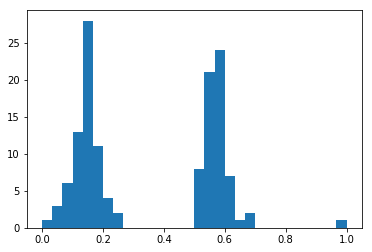

In [11]:
print(np.corrcoef(X_test["score"], X_test["pred_score"]))
plt.hist(X_test["pred_score"], bins=30)
# plt.hist(X_test["score"], bins=30)
plt.show()

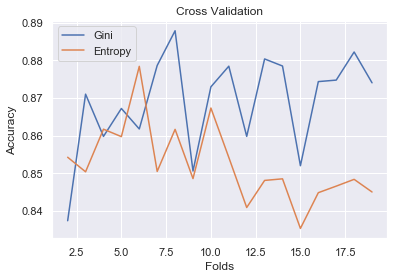

In [12]:
bigrams = pd.read_csv("bigrams.csv")
top = bigrams["bigram"].value_counts()
top = top.drop('(born,alive)')

def separate_by_id(bigrams_df):
    df_l = []
    for cid in bigrams["custom_id"].unique():
        df = bigrams[bigrams["custom_id"]==cid]
        df_l.append(df)
    return df_l

def bigram_freq(df_list: [pd.DataFrame], bigrams: [str]):
    dict_list = []
    for df in df_list:
        v = df["bigram"].value_counts()
        d = {"custom_id": df["custom_id"].iloc[0]}
        for bigram in bigrams:
            d[bigram] = 0
            if bigram in v:
                d[bigram] = v[bigram]
        dict_list.append(d)
    return dict_list

df_l = separate_by_id(bigrams)
dl = bigram_freq(df_l, top.index)
bigram_count = pd.DataFrame(dl).set_index("custom_id")
cr = pd.read_csv('Congressional Record.csv')

party = cr.set_index('Congress_id')
party = pd.DataFrame(party['Party'])

bigram_df = bigram_count.join(party)
bigram_df = bigram_df[bigram_df['Party'] != 'Independent Party']
X = bigram_df.loc[:, bigram_df.columns != 'Party']
y = bigram_df['Party']

#cross_validation
from sklearn.model_selection import cross_val_score
import seaborn as sns; sns.set()
clf_gini = DecisionTreeClassifier(criterion = 'gini')
clf_entropy = DecisionTreeClassifier(criterion = 'entropy')

num_folds = np.arange(2,20)
gini_list = []
entropy_list = []

for i in num_folds:
    gini_scores = cross_val_score(clf_gini, X, y, cv=i)
    entropy_scores = cross_val_score(clf_entropy,X, y, cv = i)
    gini_list.append(gini_scores.mean())
    entropy_list.append(entropy_scores.mean())
    
ax = sns.lineplot(num_folds,
                  gini_list,
                  label = 'Gini')
ax2 = sns.lineplot(num_folds,
                   entropy_list,
                   label = 'Entropy')
plt.xlabel("Folds")
plt.ylabel("Accuracy")
plt.title("Cross Validation")
plt.show(ax)




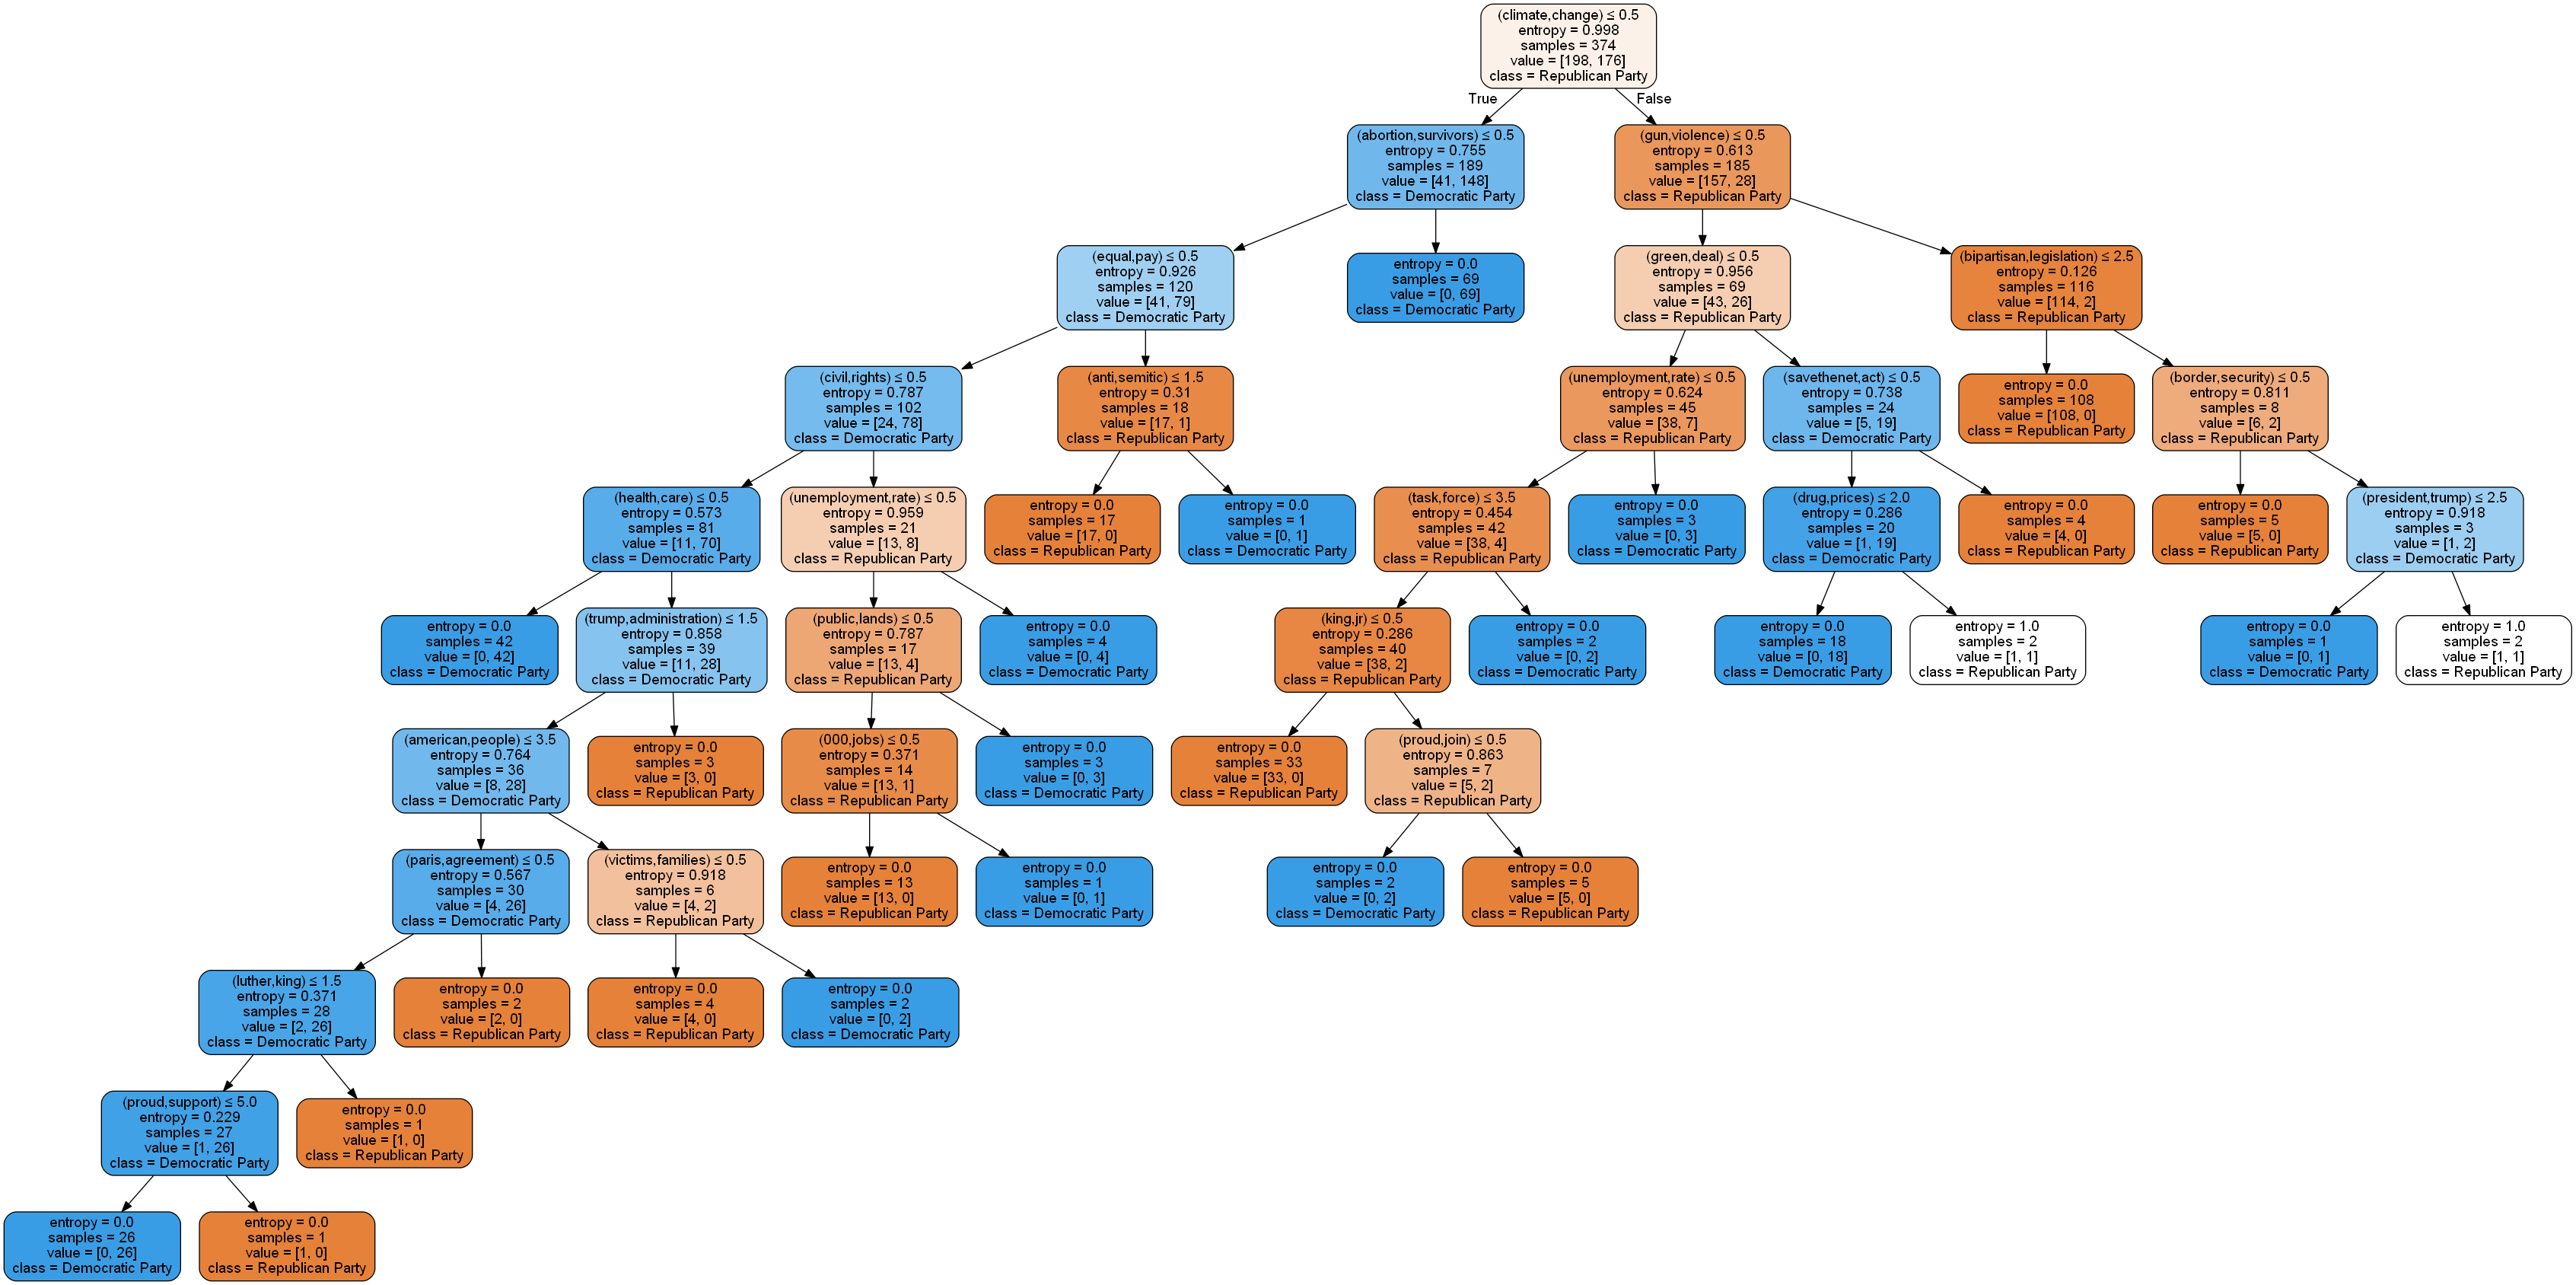

In [15]:
#visual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = DecisionTreeClassifier(criterion = 'entropy')
clf = clf.fit(X_train,y_train)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns, class_names = sorted(y.unique(), reverse = True))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('bigram.png')
Image(graph.create_png())

In [16]:
def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = DecisionTreeClassifier(random_state = 0 
      , criterion = crit
      , splitter = split
      , max_depth = depth
      , min_samples_split=min_split
      , min_samples_leaf=min_leaf)
    estimator.fit(X_train,y_train)
    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=X.columns
      , class_names= sorted(y.unique(), reverse = True)
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth= np.arange(1,15)
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…